#Luther Project: Movies and Stars

1. Read pickle files with info from BoxOfficeMojo and Oscars websites, and combine into dictionaries, one for training and one for testing.
2. Put dictionaries into Pandas dataframes to process data and make plots.
3. Perform quantile regression on log of Total Domestic Revenue versus Star Value of Cast, and plot results.
4. Compute quantiles separately for each star value, and compare with result of regression.
5. Perform ordinary linear regression on log of Revenue versus log of production budget.

In [1]:
'''
First we want to combine the information from BoxOfficeMojo and from the Oscars
website into a data structure that we can analyze with Pandas.  For each movie
we scraped from BoxOfficeMojo, we want to compute a star value for the cast using
the information we scraped from the Oscars website.
'''
import pickle
import re
from datetime import datetime
from pprint import pprint

with open('aad_oscars.pkl', 'r') as f:
    aad_dict = pickle.load(f)

for test in [False,True]:
    if test:
        test_movie_data = {}
        years           = [2014]
        ttitle          = "2014 Movies"
    else:
        movie_data      = {}
        years           = [2005,2006,2007,2008,2009,2010,2011,2012,2013]
        gtitle          = "2005 - 2013 Movies"

    for this_year in years:
        with open(str(this_year)+'_all_movie_dict.pkl', 'r') as f:
            movie_dict = pickle.load(f)

        for rank,movie in movie_dict.items():
            title      = movie["Title"]

            sum_oscnom = 0.0
            cast_value = 0.0
            nweight    = 1.0 # weight of oscar nominations relative to oscar wins in cast_value
            for actor0 in movie["Actors"]:
                if '(Voice)' in actor0: actor0 = actor0[:-8]
                if '(Narrator)' in actor0: actor0 = actor0[:-11]
                if '(Cameo)' in actor0: actor0 = actor0[:-8]
                actor      = actor0.strip('*')
                if aad_dict.has_key(actor):
                    for year in aad_dict[actor][0]:
                        if year <= this_year: cast_value += 1.0
                    for year in aad_dict[actor][1]:
                        if year <= this_year: 
                            cast_value += nweight
                            sum_oscnom += 1.0
            for director in movie["Director"]:
                if aad_dict.has_key(director):
                    for year in aad_dict[director][0]:
                        if year <= this_year: cast_value += 1.0
                    for year in aad_dict[director][1]:
                        if year <= this_year: 
                            cast_value += nweight
                            sum_oscnom += 1.0

            dtotal_str = re.compile('[,\$]').sub("", str(movie["Domestic Total"]))
            dtotal = float(dtotal_str) if dtotal_str!='None' else float('nan')

            pbudget_str = re.compile('[,\$]').sub("", str(movie["Production Budget"]))
            if 'N/A' in pbudget_str or 'None' in pbudget_str:
                pbudget = float('nan')
            elif " million" in pbudget_str:
                pbudget = float(pbudget_str[0:-8])
                pbudget *= 1000000.0
            else:
                pbudget = float(pbudget_str)

            rtime_str = str(movie["Run Time"])
            if "hrs." in rtime_str and "min." in rtime_str:
                loc1   = rtime_str.find("hrs.")
                nhours = int(rtime_str[:loc1])
                loc2   = rtime_str.find("min.")
                nmin   = int(rtime_str[loc1+4:loc2])
                rtime  = float(60*nhours + nmin)
            else:
                rtime  = float('nan')

            rating = movie["MPAA Rating"]

            genre  = movie["Genre"]

            rdate_str = movie["Release Date"]
            if isinstance(rdate_str,unicode) and "," in rdate_str:
                list1 = rdate_str.split(",")
                year  = int(list1[1])
                list2 = list1[0].split(" ")
                day   = int(list2[1])
                month_str = list2[0].strip(" ")
                month = ['January', 'February', 'March', 'April', 'May', 'June', 
                         'July', 'August', 'September', 'October', 'November', 'December'].index(month_str) + 1
                rdate = datetime(year,month,day)
            else:
                rdate = float('nan')

            year_rank = 1000*this_year + rank
            if test:
                test_movie_data[year_rank] = [title,genre,rating,cast_value,sum_oscnom,pbudget,rtime,rdate,dtotal]
            else:
                movie_data[year_rank] = [title,genre,rating,cast_value,sum_oscnom,pbudget,rtime,rdate,dtotal]

print("Number of movies in training set: %i, in test set: %i" %(len(movie_data),len(test_movie_data)))

Number of movies in training set: 5408, in test set: 693


In [2]:
'''
Print out some examples of what's in the movie and actor dictionaries.
'''
import math
for year_rank,movie in movie_data.items():
    if movie[3]==9.0 and movie[8]<=10000.0:
        print('%i (%i): %s' %(year_rank/1000,year_rank%1000,[str(movie[i]) for i in range(len(movie))]))
print('')
Actors = ["Colin Firth","Orlando Bloom","Patricia Clarkson","Amber Tamblyn","Ellen Burstyn"]
for actor in Actors:
    if actor in aad_dict: print('%s : %s' %(actor,aad_dict[actor]))

2007 (550): ['Slipstream', 'Fantasy Drama', 'R', '9.0', '7.0', 'nan', '110.0', '2007-10-26 00:00:00', '8965.0']
2011 (587): ['Main Street', 'Drama', 'PG', '9.0', '7.0', 'nan', '92.0', '2011-09-09 00:00:00', '2560.0']

Colin Firth : [[2011], [2010]]
Patricia Clarkson : [[], [2004]]
Ellen Burstyn : [[1975], [1972, 1974, 1979, 1981, 2001]]


Number of movies in training set: 5408, after filter: 3433
Number of movies in test set:     693, after filter: 399
Number of movies in combined set: 6101, after filter: 3832
Number of training+test movies with "Release Date": 6095, after filter: 3826


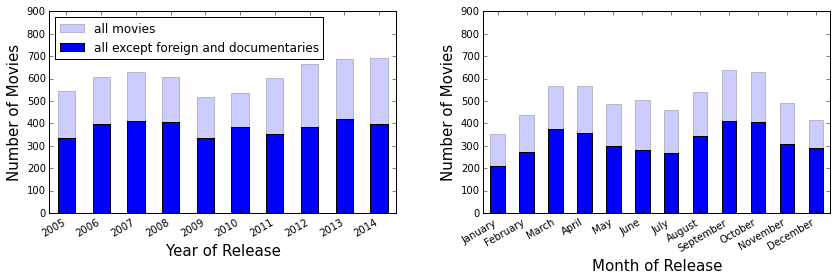

Number of training set movies with "Production Budget (US\$)" and "Domestic Total (US\$)": 1206


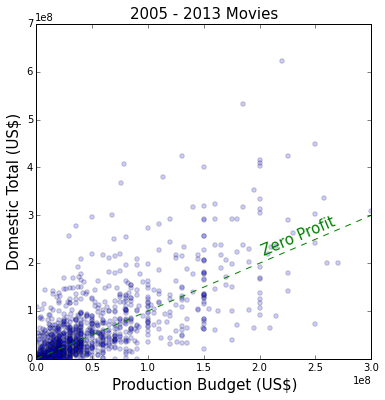

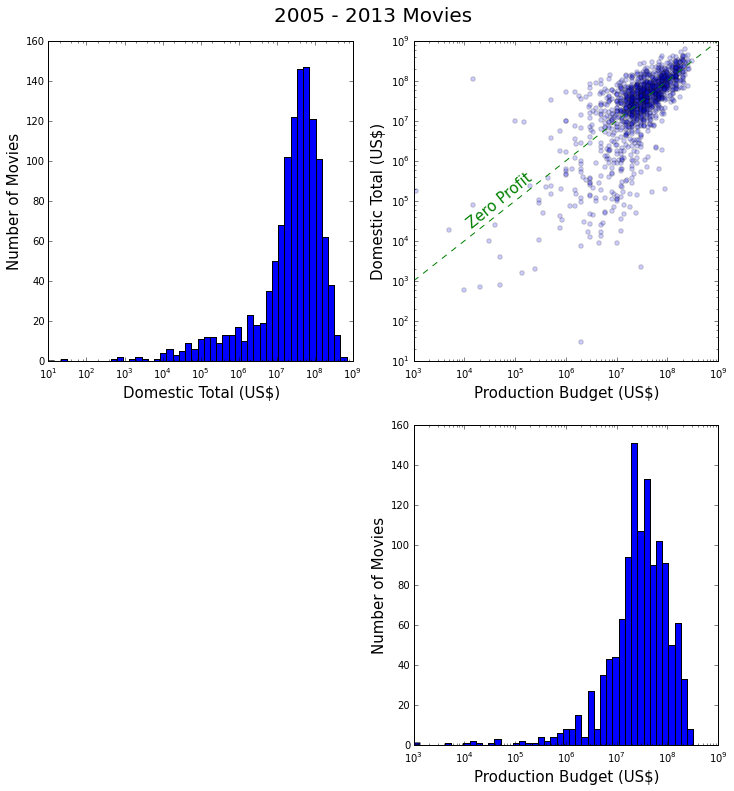

Number of training set movies with "Domestic Total (US\$)": 3313


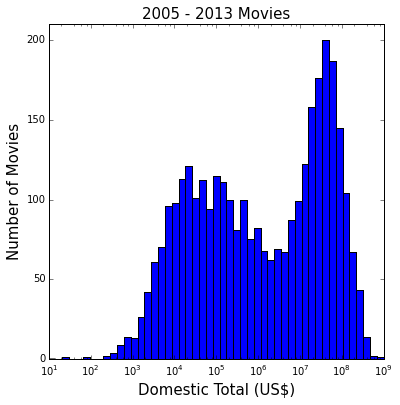

Number of training set movies with "Star Value of Cast" and "Domestic Total (US\$)": 3313


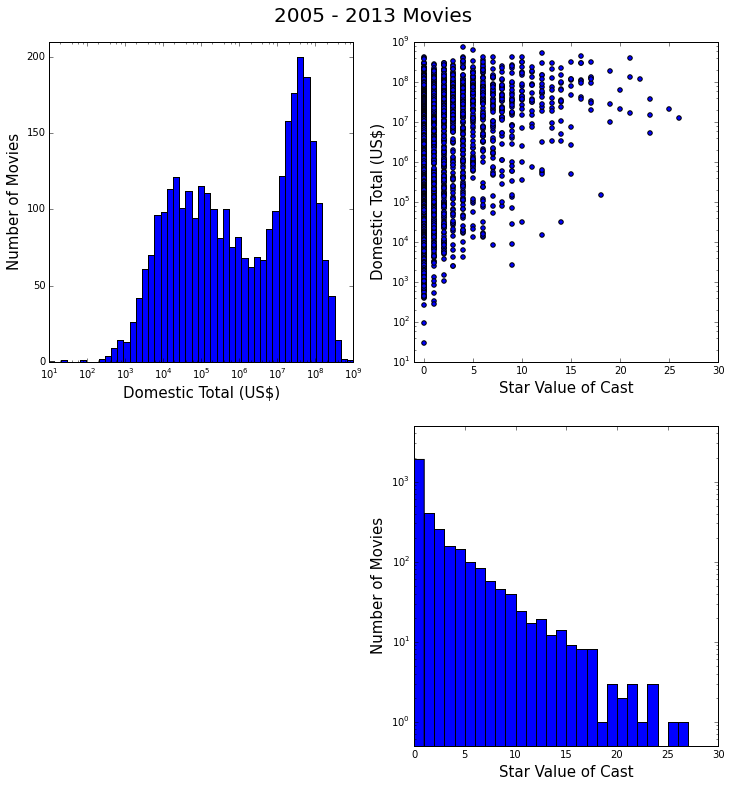

Number of training set movies with "Release Date" and "Domestic Total (US\$)": 3312
Number of training set movies with "Length (min.)" and "Domestic Total (US\$)": 3225


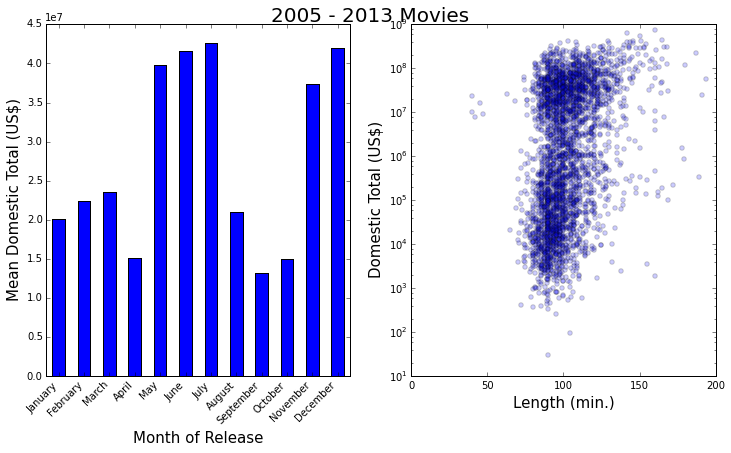

Number of training+test set movies with "Genre": 3829
For genre plot, Total: 3829, Unknown PB: 2500
Number of training+test set movies with "Release Date": 3826
For release month plot, Total: 3826, Unknown PB: 2497
For release year plot, Total: 3826, Unknown PB: 2497
Number of training+test set movies with "MPAA Rating": 3829
For MPAA rating plot, Total: 3829, Unknown PB: 2500


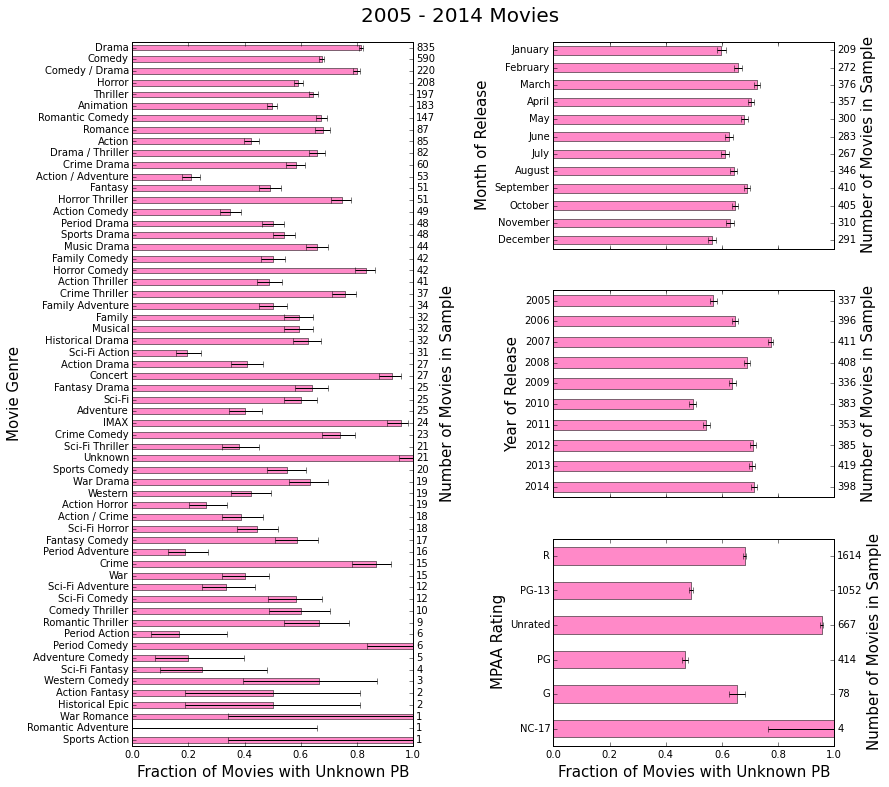

In [6]:
'''
Make a Pandas dataframe and some plots.
'''
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.special as ss
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from pprint import pprint

save   = False

Months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']
lbl0   = 'Title'
lbl1   = 'Genre'
lbl2   = 'MPAA Rating'
lbl3   = 'Star Value of Cast'
lbl4   = 'Sum of Oscar Nominations'
lbl5   = 'Production Budget (US\$)'
lbl6   = 'Length (min.)'
lbl7   = 'Release Date'
lbl8   = 'Domestic Total (US\$)'

ctitle = "2005 - 2014 Movies"

# Make Pandas dataframes with movie data and remove movies with documentary or foreign genre.
rejected_genres = ["Documentary", "Foreign", "Foreign / Action", "Foreign / Horror"]
df    = pd.DataFrame.from_dict( movie_data, orient='index' )
df.columns  = [lbl0,lbl1,lbl2,lbl3,lbl4,lbl5,lbl6,lbl7,lbl8]
df2   = df[~df[lbl1].isin(rejected_genres)]
print('Number of movies in training set: %i, after filter: %i' % (len(df),len(df2)))

tdf   = pd.DataFrame.from_dict( test_movie_data, orient='index' )
tdf.columns = [lbl0,lbl1,lbl2,lbl3,lbl4,lbl5,lbl6,lbl7,lbl8]
tdf2  = tdf[~tdf[lbl1].isin(rejected_genres)]
print('Number of movies in test set:     %i, after filter: %i' % (len(tdf),len(tdf2)))

cdf   = df.append(tdf)
cdf2 = df2.append(tdf2)
print('Number of movies in combined set: %i, after filter: %i' % (len(cdf),len(cdf2)))

# Plot distributions of movie release date (by year and by month).
fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(14,4) )
plt.subplots_adjust( wspace=0.25 )
cdf_7  = cdf[lbl7].dropna()[cdf[lbl7].dropna().dt.year>=2005]
cdf2_7 = cdf2[lbl7].dropna()[cdf2[lbl7].dropna().dt.year>=2005]
print('Number of training+test movies with "%s": %i, after filter: %i' %(lbl7,len(cdf_7),len(cdf2_7)))
cdf_7.groupby(cdf_7.dt.year).count().plot(ax=axes[0],kind="bar",alpha=0.2,label="all movies")
cdf2_7.groupby(cdf2_7.dt.year).count().plot(ax=axes[0],kind="bar",label="all except foreign and documentaries")
axes[0].set_xlabel("Year of Release",fontsize=15)
axes[0].set_ylabel("Number of Movies",fontsize=15)
axes[0].set_ylim(0.0,900.0)
axes[0].legend(loc="best")
fig.autofmt_xdate() # Rotate x-axis tick labels

cdf_7.groupby(cdf_7.dt.month).count().plot(ax=axes[1],kind="bar",alpha=0.2,label="all movies")
cdf2_7.groupby(cdf2_7.dt.month).count().plot(ax=axes[1],kind="bar",label="all except foreign and documentaries")
axes[1].set_xticklabels(Months)
axes[1].set_xlabel("Month of Release",fontsize=15)
axes[1].set_ylabel("Number of Movies",fontsize=15)
axes[1].set_ylim(0.0,900.0)
fig.autofmt_xdate()
plt.show()
if save:
    fig.savefig("Movie_Release_Dates.png")

# Make scatter plot of Total Domestic versus Production budget on a linear scale.
df2_58 = df2[[lbl5,lbl8]].dropna()
print('Number of training set movies with "%s" and "%s": %i' %(lbl5,lbl8,len(df2_58)))
fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(6,6) )
axes.scatter(df2_58[lbl5],df2_58[lbl8], alpha=0.2)
axes.plot([0.0,0.3E+09], [0.0,0.3E+09], 'g--')
axes.text(2.0E+08,2.1E+08,'Zero Profit',ha='left',va='bottom',rotation=23.0,color='green',fontsize=15)
axes.set_xlim(0.0,0.3E+09)
axes.set_xlabel(lbl5,fontsize=15)
axes.set_ylim(0.0,0.7E+09)
axes.set_ylabel(lbl8,fontsize=15)
axes.set_title(gtitle,fontsize=15)
plt.show()
if save:
    fig.savefig("DT_versus_PB_lin.png")

# Make scatter plot and projections of Total Domestic versus Production budget on a log-log scale.
fig, axes = plt.subplots( nrows=2, ncols=2, figsize=(12,12) )
plt.subplots_adjust( wspace=0.20, hspace=0.20, top=0.94 )
plt.suptitle(gtitle, fontsize=20)
axes[0,0].hist(df2_58[lbl8].values,bins=np.logspace(1.0,9.0,50))
axes[0,0].set_xscale('log')
axes[0,0].set_xlabel(lbl8,fontsize=15)
axes[0,0].set_ylabel("Number of Movies",fontsize=15)
axes[0,1].scatter(df2_58[lbl5], df2_58[lbl8], alpha=0.2)
axes[0,1].plot([1.0E+03,1.0E+09], [1.0E+03,1.0E+09], 'g--')
axes[0,1].text(1.0E+04,1.8E+04,'Zero Profit',ha='left',va='bottom',rotation=39.0,color='green',fontsize=15)
axes[0,1].set_xlim(1.0E+03,1.0E+09)
axes[0,1].set_xscale('log')
axes[0,1].set_xlabel(lbl5,fontsize=15)
axes[0,1].set_ylim(1.0E+01,1.0E+09)
axes[0,1].set_yscale('log')
axes[0,1].set_ylabel(lbl8,fontsize=15)
axes[1,0].axis("off")
axes[1,1].hist(df2_58[lbl5].values,bins=np.logspace(3.0,9.0,50))
axes[1,1].set_xscale('log')
axes[1,1].set_xlabel(lbl5,fontsize=15)
axes[1,1].set_ylabel("Number of Movies",fontsize=15)
plt.show()
if save:
    fig.savefig("DT_versus_PB_log.png")
    
# Histogram of Total Domestic regardless of whether Production Budget is available.
df2_8 = df2[[lbl8]].dropna()
print('Number of training set movies with "%s": %i' %(lbl8,len(df2_8)))
fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(6,6) )
axes.hist(df2_8[lbl8].values, bins=np.logspace(1.0,9.0,50), alpha=1.0)
axes.set_xscale('log')
axes.set_ylim(0.0,210.0)
axes.set_xlabel(lbl8,fontsize=15)
axes.set_ylabel("Number of Movies",fontsize=15)
axes.set_title(gtitle,fontsize=15)
plt.show()
if save:
    fig.savefig("DT_log.png")
    
# Make scatter plot and projections of Total Domestic versus Star Value.
df2_38 = df2[[lbl3,lbl8]].dropna()
print('Number of training set movies with "%s" and "%s": %i' %(lbl3,lbl8,len(df2_38)))
fig, axes = plt.subplots( nrows=2, ncols=2, figsize=(12,12) )
plt.subplots_adjust( wspace=0.20, hspace=0.20, top=0.94 )
plt.suptitle(gtitle, fontsize=20)
df2_38.plot(ax=axes[0,0],y=lbl8,kind='hist',bins=np.logspace(1.0,9.0,50),logx=True,ylim=(0.0,210.0),legend=False)
axes[0,0].set_xlabel(lbl8,fontsize=15)
axes[0,0].set_ylabel("Number of Movies",fontsize=15)
df2_38.plot(ax=axes[0,1],x=lbl3,y=lbl8,kind="scatter",logy=True,xlim=(-1,30),ylim=(10.0,1.0E+09))
axes[0,1].set_xlabel(lbl3,fontsize=15)
axes[0,1].set_ylabel(lbl8,fontsize=15)
axes[1,0].axis("off")
df2_38.plot(ax=axes[1,1],y=lbl3,kind='hist',bins=range(0,30,1),ylim=(0.5,0.5E+04),logy=True,legend=False)
axes[1,1].set_xlabel(lbl3,fontsize=15)
axes[1,1].set_ylabel("Number of Movies",fontsize=15)
plt.show()
if save:
    fig.savefig("DT_versus_SV.png")

# Plot mean Domestic Total versus month of release, and Domestic Total versus movie length.
df2_78 = df2[[lbl7,lbl8]][df2[lbl7].dt.year>=2005].dropna()
print('Number of training set movies with "%s" and "%s": %i' %(lbl7,lbl8,len(df2_78)))
df2_68 = df2[[lbl6,lbl8]].dropna()
print('Number of training set movies with "%s" and "%s": %i' %(lbl6,lbl8,len(df2_68)))
fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(12,6) )
plt.subplots_adjust( wspace=0.20, top=0.94 )
plt.suptitle(gtitle, fontsize=20)
df2_78[lbl8].groupby(df2_78[lbl7].dt.month).mean().plot(ax=axes[0],kind="bar")
axes[0].set_xticklabels(Months,rotation=45,ha='right')
axes[0].set_xlabel("Month of Release",fontsize=15)
axes[0].set_ylabel("Mean Domestic Total (US\$)",fontsize=15)
axes[1].scatter(df2_68[lbl6], df2_68[lbl8], alpha=0.2)
axes[1].set_xlabel(lbl6,fontsize=15)
axes[1].set_xlim(0.0,200.0)
axes[1].set_ylim(1.0E+01,1.0E+09)
axes[1].set_yscale('log')
axes[1].set_ylabel(lbl8,fontsize=15)
plt.show()

# Plots to study movies with unknown production budgets:
fig = plt.figure(figsize=(13,12))
gs  = gridspec.GridSpec(3,2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,1])
gs.update(left=0.15,top=0.94,wspace=0.50)
plt.suptitle(ctitle, fontsize=20)
cl = 0.6827 # Confidence level for Clopper-Pearson intervals on ratio of counts.

# 1. Effect of movie genre
cdf2_15 = cdf2[[lbl1,lbl5]][cdf2[lbl1]==cdf2[lbl1]]
print('Number of training+test set movies with "%s": %i' %(lbl1,len(cdf2_15)))
gdf_tot = cdf2_15[lbl1].groupby(cdf2_15[lbl1]).count()
gdf_upb = cdf2_15[lbl1][cdf2_15[lbl5]!=cdf2_15[lbl5]].groupby(cdf2_15[lbl1]).count()
gdf3 = pd.concat([gdf_tot, gdf_upb], axis=1, join='outer')
gdf3.columns = ['count0', 'count1']
gdf3.index.name = 'genre'
gdf3.sort_values(by='count0', axis=0, ascending=True, inplace=True)
gdf3['count1'].fillna(0,inplace=True) # Genres with count1=0 do not show up in gdf_upb but do in gdf_tot
gdf3['ratio']=gdf3.apply(lambda x: x[1]/x[0], axis=1)
gdf3['ci_lo']=gdf3.apply(lambda x: x[2]-(ss.btdtri(x[1],x[0]-x[1]+1,0.5*cl) if x[1]!=0 else 0.0), axis=1)
gdf3['ci_up']=gdf3.apply(lambda x: (ss.btdtri(x[1]+1,x[0]-x[1],1.0-0.5*cl) if x[1]!=x[0] else 1.0)-x[2], axis=1)
print('For genre plot, Total: %i, Unknown PB: %i' %(gdf3['count0'].sum(),gdf3['count1'].sum()))
gdf3['ratio'].plot(ax=ax1,kind="barh",color="deeppink",alpha=0.5)
ax1.errorbar(list(gdf3['ratio']),ax1.get_yticks(),xerr=[list(gdf3['ci_lo']),list(gdf3['ci_up'])],
             fmt=" ",color="black")
ax1.set_ylabel("Movie Genre",fontsize=15)
ax1.set_xlabel("Fraction of Movies with Unknown PB",fontsize=15)
ax1.set_xlim(0.0,1.0)
ax1t = ax1.twinx()
ax1t.set_ylim(ax1.get_ylim())
ax1t.set_yticks(ax1.get_yticks())
ax1t.set_yticklabels(list(gdf3['count0']))
ax1t.set_ylabel("Number of Movies in Sample",fontsize=15)

# 2. Effect of release month
cdf2_57 = cdf2[[lbl5,lbl7]][(cdf2[lbl7]==cdf2[lbl7])&(cdf2[lbl7].dropna().dt.year>=2005)]
print('Number of training+test set movies with "%s": %i' %(lbl7,len(cdf2_57)))
gdf_tot = cdf2_57[lbl7].groupby(cdf2_57[lbl7].dt.month).count()
gdf_upb = cdf2_57[lbl7][cdf2_57[lbl5]!=cdf2_57[lbl5]].groupby(cdf2_57[lbl7].dt.month).count()
gdf3 = pd.concat([gdf_tot,gdf_upb],axis=1,join='outer')
gdf3.columns = ['count0','count1']
gdf3.index.name = 'release_month'
gdf3['ratio']=gdf3.apply(lambda x: float(x[1])/x[0], axis=1)
gdf3['ci_lo']=gdf3.apply(lambda x: x[2]-(ss.btdtri(x[1],x[0]-x[1]+1,0.5*cl) if x[1]!=0 else 0.0), axis=1)
gdf3['ci_up']=gdf3.apply(lambda x: (ss.btdtri(x[1]+1,x[0]-x[1],1.0-0.5*cl) if x[1]!=x[0] else 1.0)-x[2], axis=1)
print('For release month plot, Total: %i, Unknown PB: %i' %(gdf3['count0'].sum(),gdf3['count1'].sum()))
gdf3['ratio'].plot(ax=ax2,kind="barh",color="deeppink",alpha=0.5)
ax2.errorbar(list(gdf3['ratio']),ax2.get_yticks(),xerr=[list(gdf3['ci_lo']),list(gdf3['ci_up'])],
             fmt=" ",color="black")
ax2.set_yticklabels(Months)
ax2.set_ylabel("Month of Release",fontsize=15)
ax2.invert_yaxis()
ax2.set_xlabel("Fraction of Movies with Unknown PB",fontsize=15)
ax2.set_xlim(0.0,1.0)
ax2t = ax2.twinx()
ax2t.set_ylim(ax2.get_ylim())
ax2t.set_yticks(ax2.get_yticks())
ax2t.set_yticklabels(list(gdf3['count0']))
ax2t.set_ylabel("Number of Movies in Sample",fontsize=15)

# 3. Effect of release year
gdf_tot = cdf2_57[lbl7].groupby(cdf2_57[lbl7].dt.year).count()
gdf_upb = cdf2_57[lbl7][cdf2_57[lbl5]!=cdf2_57[lbl5]].groupby(cdf2_57[lbl7].dt.year).count()
gdf3 = pd.concat([gdf_tot,gdf_upb],axis=1,join='outer')
gdf3.columns = ['count0','count1']
gdf3.index.name = 'release_year'
gdf3['ratio']=gdf3.apply(lambda x: float(x[1])/x[0], axis=1)
gdf3['ci_lo']=gdf3.apply(lambda x: x[2]-(ss.btdtri(x[1],x[0]-x[1]+1,0.5*cl) if x[1]!=0 else 0.0), axis=1)
gdf3['ci_up']=gdf3.apply(lambda x: (ss.btdtri(x[1]+1,x[0]-x[1],1.0-0.5*cl) if x[1]!=x[0] else 1.0)-x[2], axis=1)
gdf3['ratio'].plot(ax=ax3,kind="barh",color="deeppink",alpha=0.5)
ax3.errorbar(list(gdf3['ratio']),ax3.get_yticks(),xerr=[list(gdf3['ci_lo']),list(gdf3['ci_up'])],
             fmt=" ",color="black")
print('For release year plot, Total: %i, Unknown PB: %i' %(gdf3['count0'].sum(),gdf3['count1'].sum()))
ax3.set_ylabel("Year of Release",fontsize=15)
ax3.invert_yaxis()
ax3.set_xlabel("Fraction of Movies with Unknown PB",fontsize=15)
ax3.set_xlim(0.0,1.0)
ax3t = ax3.twinx()
ax3t.set_ylim(ax3.get_ylim())
ax3t.set_yticks(ax3.get_yticks())
ax3t.set_yticklabels(list(gdf3['count0']))
ax3t.set_ylabel("Number of Movies in Sample",fontsize=15)

# 4. Effect of MPAA Rating
cdf2_25 = cdf2[[lbl2,lbl5]][cdf2[lbl2]==cdf2[lbl2]]
print('Number of training+test set movies with "%s": %i' %(lbl2,len(cdf2_25)))
gdf_tot = cdf2_25[lbl2].groupby(cdf2_25[lbl2]).count()
gdf_upb = cdf2_25[lbl2][cdf2_25[lbl5]!=cdf2_25[lbl5]].groupby(cdf2_25[lbl2]).count()
gdf3 = pd.concat([gdf_tot, gdf_upb], axis=1, join='outer')
gdf3.columns = ['count0', 'count1']
gdf3.index.name = 'MPAA_Rating'
gdf3.sort_values(by='count0', axis=0, ascending=True, inplace=True)
gdf3['ratio']=gdf3.apply(lambda x: float(x[1])/x[0], axis=1)
gdf3['ci_lo']=gdf3.apply(lambda x: x[2]-(ss.btdtri(x[1],x[0]-x[1]+1,0.5*cl) if x[1]!=0 else 0.0), axis=1)
gdf3['ci_up']=gdf3.apply(lambda x: (ss.btdtri(x[1]+1,x[0]-x[1],1.0-0.5*cl) if x[1]!=x[0] else 1.0)-x[2], axis=1)
print('For MPAA rating plot, Total: %i, Unknown PB: %i' %(gdf3['count0'].sum(),gdf3['count1'].sum()))
gdf3['ratio'].plot(ax=ax4,kind="barh",color="deeppink",alpha=0.5)
ax4.errorbar(list(gdf3['ratio']),ax4.get_yticks(),xerr=[list(gdf3['ci_lo']),list(gdf3['ci_up'])],
             fmt=" ",color="black")
ax4.set_ylabel("MPAA Rating",fontsize=15)
ax4.set_xlabel("Fraction of Movies with Unknown PB",fontsize=15)
ax4.set_xlim(0.0,1.0)
ax4t = ax4.twinx()
ax4t.set_ylim(ax4.get_ylim())
ax4t.set_yticks(ax4.get_yticks())
ax4t.set_yticklabels(list(gdf3['count0']))
ax4t.set_ylabel("Number of Movies in Sample",fontsize=15)

plt.show()
if save:
    fig.savefig("G_RD_R.png")


Fit 1: constant + linear terms, using all data points:

                         QuantReg Regression Results                          
Dep. Variable:                  LogDT   Pseudo R-squared:              0.06938
Model:                       QuantReg   Bandwidth:                      0.4122
Method:                 Least Squares   Sparsity:                        5.709
Date:                Fri, 04 Dec 2015   No. Observations:                 3313
Time:                        19:55:27   Df Residuals:                     3311
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.8087      0.036    104.389      0.000         3.737     3.880
SVC            0.1757      0.012     14.621      0.000         0.152     0.199

Fit 2: constant + linear terms, using all data points with SVC<=14:

    

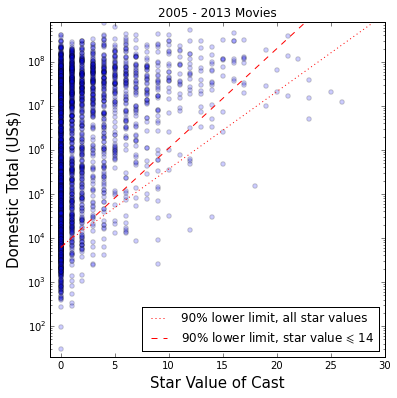

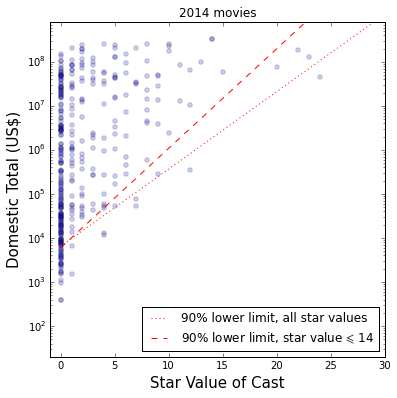

In [10]:
'''
Perform quantile regression on "Domestic Total" versus "Star Value of Cast" 
to determine a lower limit on the former as a function of the latter.  We
want to be able to make a prediction of the form "If the star value of the
cast equals x, then there is a probability of 90% that the domestic total 
will exceed y", where y is an increasing function of x.
'''
from __future__ import print_function
import patsy
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg

def map_rows(inrow):
    outrow = inrow[:] # This preserves the input data structure (list or series...) in the output
    outrow[1] = np.log10(outrow[1])
    return outrow

# Define two fit models and perform corresponding fits.
qval        = 0.10
df3         = df2[[lbl3,lbl8]].dropna()
df3.columns = ['SVC','LogDT']
df3.apply(map_rows,axis=1)
model1      = smf.quantreg('LogDT ~ SVC', df3[df3.SVC<=30])
result1     = model1.fit(q=qval)
model2      = smf.quantreg('LogDT ~ SVC', df3[df3.SVC<=14])
result2     = model2.fit(q=qval)
c1          = [result1.params['Intercept'], result1.params['SVC']]
c2          = [result2.params['Intercept'], result2.params['SVC']]

# Print out fit results.
print('\nFit 1: constant + linear terms, using all data points:\n')
print(result1.summary())
print('\nFit 2: constant + linear terms, using all data points with SVC<=14:\n')
print(result2.summary())

print('\n                  |         Fit to all data points         | Fit to all data points with SVC<=14')
print('SVC Ntotal Ctotal | Limit       Nbelow           Cbelow    |  Limit       Nbelow           Cbelow')
print('------------------|----------------------------------------|----------------------------------------')
ctotal  = 0.0
cbelow1 = 0.0
cbelow2 = 0.0
for i in range(31):
    LogDTLim1 = c1[0]+c1[1]*i
    LogDTLim2 = c2[0]+c2[1]*i
    ntotal = len(df3[df3.SVC==i])
    ctotal += ntotal
    if ntotal != 0:
        nbelow1 = len(df3[(df3.SVC==i) & (df3.LogDT<=LogDTLim1)])
        cbelow1 += nbelow1
        nbfrac1 = (100.0*nbelow1)/ntotal
        cbfrac1 = (100.0*cbelow1)/ctotal
        nbelow2 = len(df3[(df3.SVC==i) & (df3.LogDT<=LogDTLim2)])
        cbelow2 += nbelow2
        nbfrac2 = (100.0*nbelow2)/ntotal
        cbfrac2 = (100.0*cbelow2)/ctotal
        print('%2d   %4d   %4d  |%6.3f  %4d (%6.2f%%)   %4d (%6.2f%%) | %6.3f  %4d (%6.2f%%)   %4d (%6.2f%%)'\
              %(i,ntotal,ctotal,LogDTLim1,nbelow1,nbfrac1,cbelow1,cbfrac1,
                                LogDTLim2,nbelow2,nbfrac2,cbelow2,cbfrac2))
print('----------------------------------------------------------------------------------------------------')

# Apply fit results to test data set.
tdf3         = tdf2[[lbl3,lbl8]].dropna()
tdf3.columns = ['SVC','LogDT']
tdf3.apply(map_rows,axis=1)
nttotal      = len(tdf3)
ntbelow1     = len(tdf3[tdf3.LogDT<=c1[0]+c1[1]*tdf3.SVC])
ntbfrac1     = (100.0*ntbelow1)/nttotal
ntbelow2     = len(tdf3[tdf3.LogDT<=c2[0]+c2[1]*tdf3.SVC])
ntbfrac2     = (100.0*ntbelow2)/nttotal
print('\nTest data set: Total=%i, Below(fit1)=%i (%f%%), Below(fit2)=%i (%f%%)' \
      %(nttotal,ntbelow1,ntbfrac1,ntbelow2,ntbfrac2))

# Make plots.
q1label    = '{0:2.0f}% lower limit, all star values'.format(100.0*(1.0-qval))
q2label    = r'{0:2.0f}% lower limit, star value $\leqslant$ 14'.format(100.0*(1.0-qval))
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6) )
df2.plot(ax=axis,x=lbl3,y=lbl8,kind="scatter",logy=True,xlim=(-1,30),ylim=(20.0,0.8E+09),alpha=0.2,title=gtitle)
axis.set_xlabel(lbl3,fontsize=15)
axis.set_ylabel(lbl8,fontsize=15)
x      = np.arange(0.0, 30.0, 1.0)
get_y  = lambda c: 10**(c[0] + c[1]*x)
y1     = get_y(c1)
y2     = get_y(c2)
axis.plot(x, y1, linestyle='dotted', color='red', label=q1label)
axis.plot(x, y2, linestyle='dashed', color='red', label=q2label)
plt.legend(loc="lower right")
plt.show()
fig.savefig("DT_versus_SV_2fits.png")

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6) )
ttitle = "2014 movies"
tdf2.plot(ax=axis,x=lbl3,y=lbl8,kind="scatter",logy=True,xlim=(-1,30),ylim=(20.0,0.8E+09),alpha=0.2,title=ttitle)
axis.set_xlabel(lbl3,fontsize=15)
axis.set_ylabel(lbl8,fontsize=15)
axis.plot(x, y1, linestyle='dotted', color='red', label=q1label)
axis.plot(x, y2, linestyle='dashed', color='red', label=q2label)
plt.legend(loc="lower right")
plt.show()

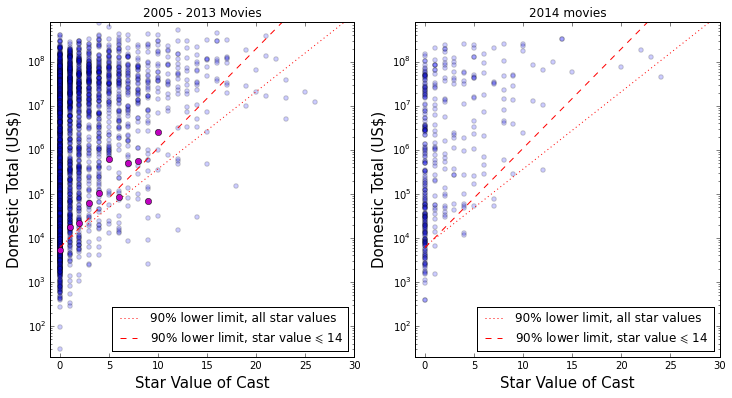

In [13]:
'''
Here we compute data percentiles as a function of star value of cast 
and compare with result of quantile regression.
'''
import math

# First compute percentile in each SVC bucket separately, for SVC<=9
lolim_list = []
svc_list   = []
for star_value in range(10):
    dt_list = []
    for movie in movie_data.values():
        if movie[3]==star_value and movie[1] not in rejected_genres:
            if movie[8]==movie[8]:            # Eliminate NaN in movie[8] (domestic total)
                dt_list.append(movie[8])

    dt_list.sort()
    rindex = qval*len(dt_list)
    rfloor = math.floor(rindex)
    rceil  = math.ceil(rindex)
    iindex = int(rfloor if rindex-rfloor<rceil-rindex else rceil)-1
    lolim  = dt_list[iindex]
    lolim_list.append(lolim)
    svc_list.append(star_value)
    
# Next, compute percentile in all SVC>9 buckets combined.
dt_list = []
for movie in movie_data.values():
    if movie[3]>9 and movie[1] not in rejected_genres:
        if movie[8]==movie[8]:
            dt_list.append(movie[8])

dt_list.sort()
rindex = qval*len(dt_list)
rfloor = math.floor(rindex)
rceil  = math.ceil(rindex)
iindex = int(rfloor if rindex-rfloor<rceil-rindex else rceil)-1
lolim  = dt_list[iindex]
lolim_list.append(lolim)
svc_list.append(10)

# Make a plot
q1label   = '{0:2.0f}% lower limit, all star values'.format(100.0*(1.0-qval))
q2label   = r'{0:2.0f}% lower limit, star value $\leqslant$ 14'.format(100.0*(1.0-qval))
fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(12,6) )
df2.plot(ax=axis[0],x=lbl3,y=lbl8,kind="scatter",logy=True,xlim=(-1,30),ylim=(20.0,0.8E+09),alpha=0.2,title=gtitle)
axis[0].set_xlabel(lbl3,fontsize=15)
axis[0].set_ylabel(lbl8,fontsize=15)
axis[0].plot(x, y1, linestyle='dotted', color='red', label=q1label)
axis[0].plot(x, y2, linestyle='dashed', color='red', label=q2label)
axis[0].plot(svc_list,lolim_list, 'mo')
axis[0].legend(loc="lower right")

ttitle = "2014 movies"
tdf2.plot(ax=axis[1],x=lbl3,y=lbl8,kind="scatter",logy=True,xlim=(-1,30),ylim=(20.0,0.8E+09),alpha=0.2,title=ttitle)
axis[1].set_xlabel(lbl3,fontsize=15)
axis[1].set_ylabel(lbl8,fontsize=15)
axis[1].plot(x, y1, linestyle='dotted', color='red', label=q1label)
axis[1].plot(x, y2, linestyle='dashed', color='red', label=q2label)
axis[1].legend(loc="lower right")
plt.show()
fig.savefig("DT_versus_SV_2fits_sq_2014.png")

                            OLS Regression Results                            
Dep. Variable:                  LogDT   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.389e+05
Date:                Thu, 03 Dec 2015   Prob (F-statistic):               0.00
Time:                        17:22:18   Log-Likelihood:                -1253.6
No. Observations:                1206   AIC:                             2509.
Df Residuals:                    1205   BIC:                             2514.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
LogPB          0.9873      0.003    372.732      0.0

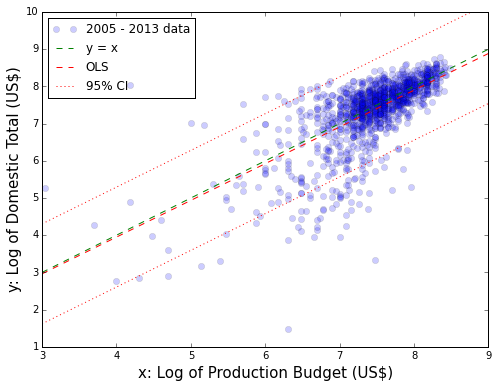

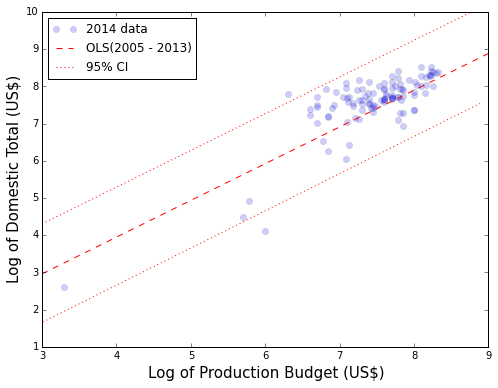

In [18]:
'''
Do an ordinary least-squares regression of total domestic revenue versus production budget.
'''
%matplotlib inline
import statsmodels.formula.api as smf
#from __future__ import print_function
import numpy as np
#import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import pandas as pd

def map_rows2(inrow):
    outrow = inrow[:]
    outrow[0] = np.log10(outrow[0])
    outrow[1] = np.log10(outrow[1])
    return outrow

# Define two fit models and perform corresponding fits.
df4          = df2[[lbl5,lbl8]].dropna()
df4.columns  = ['LogPB','LogDT']
df4.apply(map_rows2,axis=1)

tdf4         = tdf2[[lbl5,lbl8]].dropna()
tdf4.columns = ['LogPB','LogDT']
tdf4.apply(map_rows2,axis=1)

model        = smf.ols("LogDT ~ LogPB-1", df4).fit()  # Constrain the fit to go through (0,0)
print(model.summary())
fitc1        = model.params["LogPB"]

predictions  = model.predict(tdf4)

# Make plots.
xarray          = [3.0,9.0]
yarray          = [x*fitc1 for x in xarray]
xxarray         = [[x] for x in xarray]
prstd,iv_l,iv_u = wls_prediction_std(model,exog=xxarray,alpha=0.05)

fig,ax=plt.subplots(figsize=(8,6))
ax.plot(df4.LogPB,df4.LogDT,'o',label="2005 - 2013 data",alpha=0.2)
ax.plot([3.0,9.0], [3.0,9.0], 'g--', label="y = x")
ax.plot(xarray, yarray, 'r--', label="OLS")
ax.plot(xarray, iv_u, 'r:', label="95% CI")
ax.plot(xarray, iv_l, 'r:')
ax.set_xlim(3.0,9.0)
ax.set_ylim(1.0,10.0)
plt.xlabel("x: Log of Production Budget (US\$)", fontsize=15)
plt.ylabel("y: Log of Domestic Total (US\$)", fontsize=15)
ax.legend(loc='upper left')
plt.show()
if save:
    fig = ax.get_figure()
    fig.savefig("DT_vs_PB_fit.pdf")

fig,ax=plt.subplots(figsize=(8,6))
ax.plot(tdf4.LogPB,tdf4.LogDT,'o',label="2014 data",alpha=0.2)
ax.plot(xarray, yarray, 'r--', label="OLS(2005 - 2013)")
ax.plot(xarray, iv_u, 'r:', label="95% CI")
ax.plot(yarray, iv_l, 'r:')
ax.set_xlim(3.0,9.0)
ax.set_ylim(1.0,10.0)
plt.xlabel("Log of Production Budget (US\$)", fontsize=15)
plt.ylabel("Log of Domestic Total (US\$)", fontsize=15)
ax.legend(loc='best')
plt.show()
if save:
    fig = ax.get_figure()
    fig.savefig("DT_vs_PB_test.pdf")